In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from financepy.utils import *
from financepy.products.equity import *
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

### Black Scholes Merton Hedging Frequency Analysis

We create a function called OptionSim that simulates the delta hedging of a European call option from trade date until expiry. It should use the
function in (a) for calculating the option price and delta. The function inputs include the option strike K, spot price of the stock S, risk-free rate r, the stock price drift μ (we do not assume that the stock grows at r), volatility σ and years to expiry
T. The other input must be the hedging frequency per year N.

The dynamics of the stock price should be assumed to be lognormal with a drift μ
(hedging does not have to set equal μ = r as the true stock price evolution is not
risk-neutral) and a volatility σReal. The output of your function should be a tuple that
has 6 elements:
* The terminal stock price S(T) in the simulation path
* The call option payoff
* The number of shares held in the hedging portfolio
* The cash balance in the hedging portfolio
* The total value of the shares and cash held
* The replicating error which is the difference between the total value of the hedging portfolio and the option payoff.


In [13]:
def OptionSim(S0, K, r, sigma, mu, T, Hedging_freq):

    np.random.seed(None) 
    
    q = r - mu # allows to check cases if r != mu
    dt = 1/Hedging_freq
    S_t = np.zeros((Hedging_freq)*T)
    S_t[0] = S0  
      
    C = bs_value(S0, T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value) # compute call value and delta value
    Delta = bs_delta(S0, T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value)  
    
    b = C - Delta*S0 
    g = np.random.standard_normal(Hedging_freq*T) # draw outside of for loop
        
    for i in range(1, (Hedging_freq)*T): # loop over hedging freq
        Deltat = Delta
        S_t[i] = S_t[i-1]*np.exp((mu -0.5*sigma ** 2)*dt+ sigma*np.sqrt(dt)*g[i-1]) 

        time_to_expiry = T - i *dt # remaining time
        Delta = bs_delta(S_t[i], T, K, r, q, sigma, OptionTypes.EUROPEAN_CALL.value) 
        b = b*exp(r*dt)+(Deltat-Delta)*S_t[i] # change in cash balance
        
        Hedge = b + Delta*S_t[-1] # update hedge ptf value, delta and cash balance
        Deltat = Delta
        cashbalance = b
        Payoff = max(S_t[-1]-K,0)
        Error = Payoff - Hedge
        
             
    result = {"S_T": S_t[-1], "Payoff": Payoff, 'Delta': Deltat, 'Cash_Balance': cashbalance,
                "Hedging_ptf": Hedge, "Hedging_err": Error}
    
    return result

# let's see our hedging strategy for a call ATM, S=100, r= 5%, mu = 2%, sigma = 35% and T= 2 years
# we assume monthly hedging
OptionSim(100, 100, 0.05, 0.35, 0.05, 2, 12) 

{'S_T': 162.03019177522154,
 'Payoff': 62.03019177522154,
 'Delta': 0.9228551892733132,
 'Cash_Balance': -87.36832063881165,
 'Hedging_ptf': 62.16208265990166,
 'Hedging_err': -0.1318908846801179}

hedging error over 10,000 different paths.

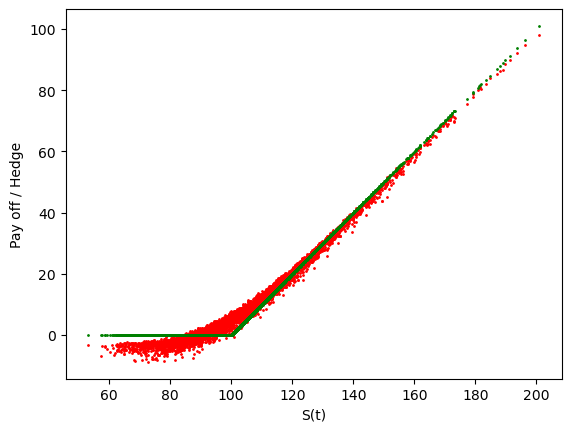

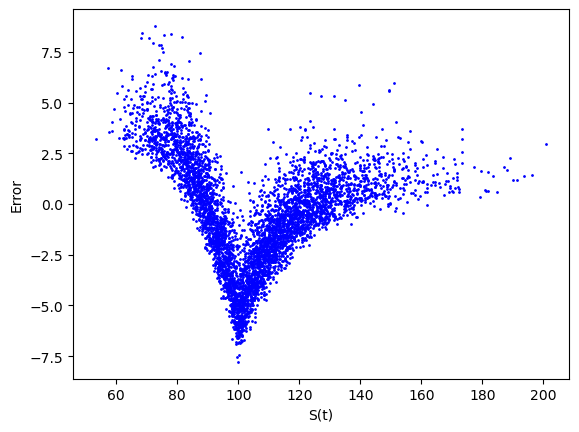

In [14]:
def hedgingError(S0, K, r, sigma, mu, T, Hedging_freq, Nb_paths):
    
    S_t = []
    Payoff = []
    Deltat = []
    Hedge = []
    Error = []

    for i in range(0,Nb_paths):
        res = OptionSim(S0, K, r, sigma, mu, T, Hedging_freq)
        S_t.append(res["S_T"])
        Error.append(res["Hedging_err"])
        Payoff.append(res["Payoff"])
        Deltat.append(res["Delta"])
        Hedge.append(res["Hedging_ptf"])
    
    plt.scatter(S_t, Hedge, s=1, color='red', label='Hedge')
    plt.scatter(S_t, Payoff, s=1, color='green', label='Pay Off')
    plt.xlabel('S(t)')
    plt.ylabel('Pay off / Hedge')
    plt.show()
    plt.scatter(S_t, Error, s=1, color='blue', label='Hedge')
    plt.xlabel('S(t)')
    plt.ylabel('Error')

# example wiht for 5000 paths & monthly hedging
hedgingError(100,100,0.05,0.20,0.05,1,12,5000)  

Now we consider a call option with S(0) = 100, K = 100, r = 5%, T = 1.0 and σ = 20%.
Assume here that μ = 5%. For this option, make a scatterplot of the hedging error (yaxis)
versus the terminal stock price (x-axis) for N = 12 (monthly), N = 52 (weekly)
and N = 252 (daily). Use different symbols or colours to distinguish the points.

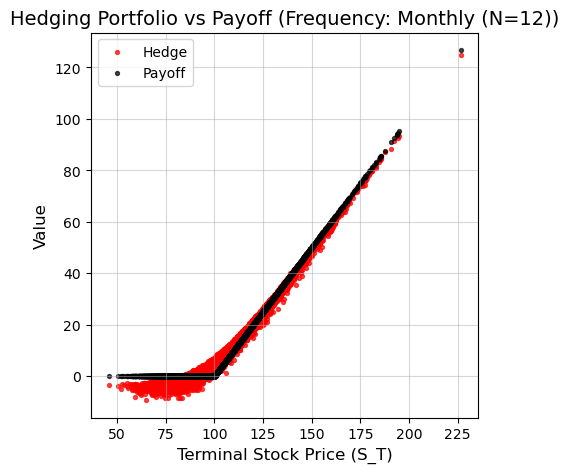

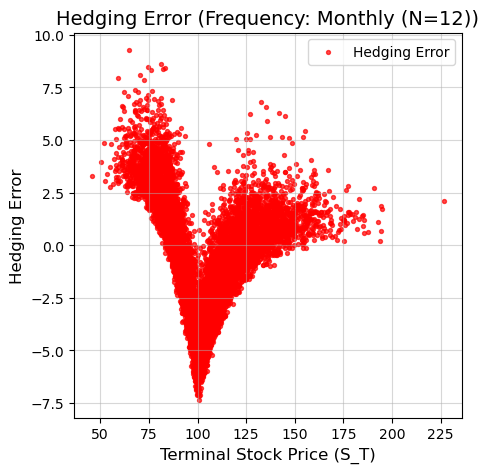

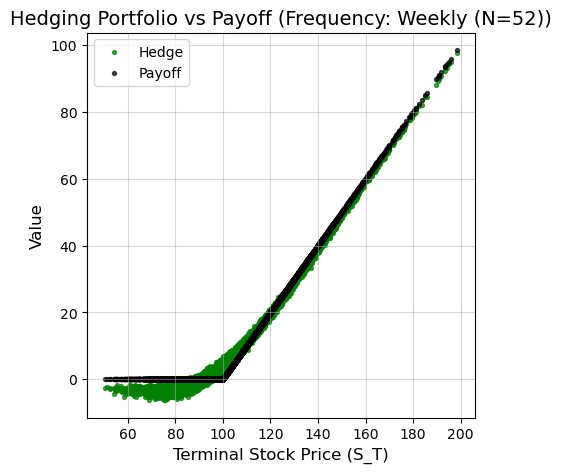

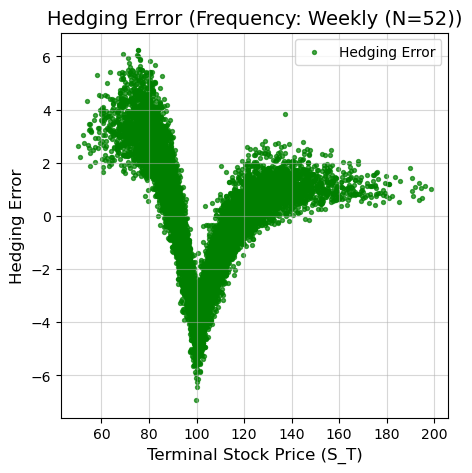

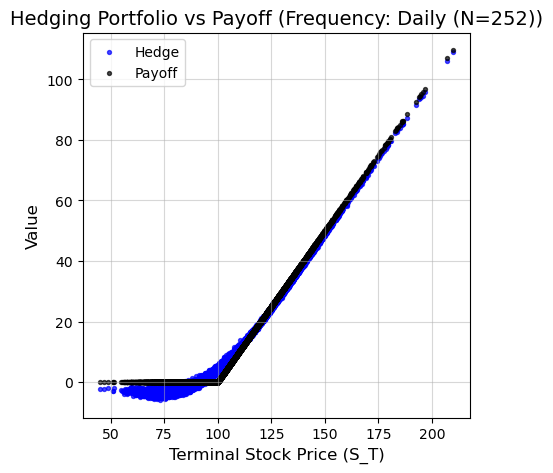

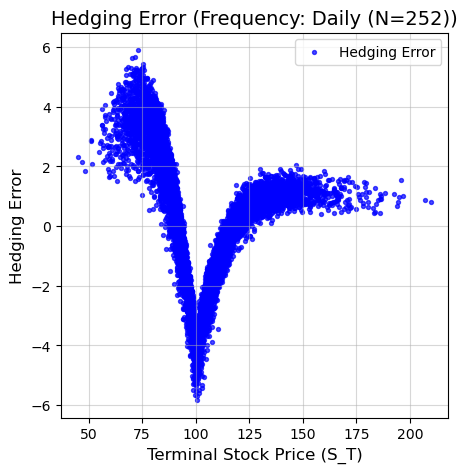

In [15]:
def hedgingError_multiple_frequencies(S0, K, r, sigma, mu, T, Nb_paths):
    # we define proper color & label for each frequency
    hedging_frequencies = {
        12: {'color': 'red', 'label': 'Monthly (N=12)'},
        52: {'color': 'green', 'label': 'Weekly (N=52)'},
        252: {'color': 'blue', 'label': 'Daily (N=252)'}
    }
    # Prepare to store results
    results = []
    
    # iterate over the frequencies & theis characteristics
    for N, style in hedging_frequencies.items():
        S_t = np.zeros(Nb_paths)
        Payoff = np.zeros(Nb_paths)
        Hedge = np.zeros(Nb_paths)
        Error = np.zeros(Nb_paths)

        for i in range(Nb_paths): # call option sim for each frq
            res = OptionSim(S0, K, r, sigma, mu, T, N) 
            S_t[i] = res["S_T"]
            Payoff[i] = res["Payoff"]
            Hedge[i] = res["Hedging_ptf"]
            Error[i] = res["Hedging_err"]

        # Calculate mean and variance of hedging errors
        mean_error = np.mean(Error)
        variance_error = np.var(Error)

        # Store the results for this frequency
        results.append([style['label'], mean_error, variance_error])

        # First graph: Hedge vs Payoff
        plt.figure(figsize=(5, 5))
        plt.scatter(S_t, Hedge, s=8, color=style['color'], alpha=0.7, label='Hedge')
        plt.scatter(S_t, Payoff, s=8, color='black', alpha=0.7, label='Payoff')
        plt.xlabel('Terminal Stock Price (S_T)', fontsize=12)
        plt.ylabel('Value', fontsize=12)
        plt.title(f'Hedging Portfolio vs Payoff (Frequency: {style["label"]})', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.5)
        plt.show()

        # Second graph: Hedging Error
        plt.figure(figsize=(5, 5))
        plt.scatter(S_t, Error, s=8, color=style['color'], alpha=0.7, label='Hedging Error')
        plt.xlabel('Terminal Stock Price (S_T)', fontsize=12)
        plt.ylabel('Hedging Error', fontsize=12)
        plt.title(f'Hedging Error (Frequency: {style["label"]})', fontsize=14)
        plt.legend(fontsize=10)
        plt.grid(alpha=0.5)
        plt.show()

     # Create a DataFrame for easy table presentation
    df = pd.DataFrame(results, columns=['Frequency', 'Mean Hedging Error', 'Variance Hedging Error'])

    return df

S_0 = 100
K = 100
r= 0.05
T = 1
sigma = 0.2
mu = 0.05
Nb_paths= 10000

errors = hedgingError_multiple_frequencies(S_0, K, r, sigma, mu, T, Nb_paths)

For each value of N also calculate the mean and variance of this option hedging error
over 10,000 different paths. You can use this to generate the answers to the remaining
parts of this question. Present this in a simple table format.

In [16]:
# We have included the errors calculation in the previous function
errors

,Frequency,Mean Hedging Error,Variance Hedging Error
0,Monthly (N=12),-0.628097,7.095042
1,Weekly (N=52),-0.158222,5.209518
2,Daily (N=252),-0.051046,4.766258


As we increase the the hedging frequency, both the mean hedging error the variance decreases (as is measures the dispersion of our values).

The greater the frequency N (or the smaller 1/N), the smaller the mean and variance error

For the same call option, we calculate the mean absolute error value and the variance of
the hedging error for μ = 2.5%, 5.0%, 7.5%, 10% by sampling 10, 000 hedging paths
using N = 52. Show the results in a table. 

In [17]:
results = []
drift_values = [0.025, 0.05, 0.075, 0.1]
frequency = 52

for mu in drift_values:  # Iterate over the provided drift values
    Error = []

    for _ in range(Nb_paths):  # Simulate over Nb_paths paths
        res = OptionSim(S_0, K, r, sigma, mu, T, frequency)  # Use OptionSim for each path
        Error.append(res["Hedging_err"])  # Collect hedging errors

    # Calculate mean absolute error and variance of hedging error
    mean_absolute_error = np.mean(np.abs(Error))
    variance_error = np.var(Error)

    # Store the results for this drift value
    results.append([mu * 100, mean_absolute_error, variance_error])  # Drift in percentage

# Create a DataFrame for easy table presentation
weekly_drift_hedge_errors = pd.DataFrame(results, columns=['Drift (μ, %)', 'Mean Absolute Error', 'Variance of Hedging Error'])

In [18]:
weekly_drift_hedge_errors

,"Drift (μ, %)",Mean Absolute Error,Variance of Hedging Error
0,2.5,2.297564,5.255321
1,5.0,1.864815,5.239963
2,7.5,3.046156,6.699070
3,10.0,5.098034,10.323269


we observes that when µ (mu) increases, the absolute mean error increases. This is coherent with the fact we assumed stock prices to follow a log normal process : the stock process follows a Log-N µ, Variance). Hence if we increase µ, the mean of errors will increase. The "larger" the mean error, the larger the variance of errors, explaining the increase in variance for increasing µ